In [2]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, normalize
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
data = pd.read_csv("reproducible_dataset_iclr2017.csv")
data.head(3)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label,max_pub,max_cit
0,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,20,1,8,1,0,1,0,Reject,83,1908
1,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,16,1,2,1,1,1,0,Accept,113,3062
2,HkIQH7qel,4,73,8,1007,155,1,21,2016,1,...,15,0,9,1,1,1,2,Reject,47,2464


In [5]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg',
       'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'max_pub', 'max_cit'],
      dtype='object')

## Augment the GS information

In [8]:
with open("features/GS_MMM_cit_pub_count_2017.pickle", "rb") as f:
    gs_mmm = pickle.load(f)

In [9]:
gs_mmm["HyenWc5gx"]

{'authors': ['Matthew Riemer', 'Elham Khabiri', 'Richard Goodwin'],
 'cit_count_gs': [9, 199, 816],
 'gs_cit_stat': [341.3333333333333, 816, 9, 199.0],
 'gs_pub_stat': [24.0, 42, 7, 23.0],
 'hindex': [9.0, 7.5, 24.0],
 'id': 'HyenWc5gx',
 'label': 'Reject',
 'pub_count_gs': [7, 23, 42],
 'title': 'Representation Stability as a Regularizer for Improved Text Analytics Transfer Learning'}

In [27]:
def gs_pub_func(row):
    pid = row["id"]
    if "gs_pub_stat" in gs_mmm[pid]:
        return pd.Series([gs_mmm[pid]["gs_pub_stat"][0], gs_mmm[pid]["gs_pub_stat"][1], gs_mmm[pid]["gs_pub_stat"][2], gs_mmm[pid]["gs_cit_stat"][3]])
    else:
        return pd.Series([0,0,0,0])

In [28]:
data[['gs_pub_mean', 'gs_pub_max', 'gs_pub_min', 'gs_pub_med']] = data.apply(gs_pub_func, axis="columns")

In [25]:
def gs_cit_func(row):
    pid = row["id"]
    if "gs_cit_stat" in gs_mmm[pid]:
        return pd.Series([gs_mmm[pid]["gs_cit_stat"][0], gs_mmm[pid]["gs_cit_stat"][1], gs_mmm[pid]["gs_cit_stat"][2], gs_mmm[pid]["gs_cit_stat"][3]])
    else:
        return pd.Series([0,0,0,0])

In [26]:
data[['gs_cit_mean', 'gs_cit_max', 'gs_cit_min', 'gs_cit_med']] = data.apply(gs_cit_func, axis="columns")

In [34]:
print(data.columns)
data.head(2)

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg',
       'contains_sota', 'num_recent_refs', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_max', 'gs_cit_min',
       'gs_cit_med', 'gs_pub_mean', 'gs_pub_max', 'gs_pub_min', 'gs_pub_med'],
      dtype='object')


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,contains_ml_keyword,...,max_pub,max_cit,gs_cit_mean,gs_cit_max,gs_cit_min,gs_cit_med,gs_pub_mean,gs_pub_max,gs_pub_min,gs_pub_med
0,HyenWc5gx,3,87,11,1464,219,3,40,2016,1,...,83,1908,341.333333,816.0,9.0,199.0,24.0,42.0,7.0,199.0
1,Hk8TGSKlg,2,74,9,769,109,2,17,2016,1,...,113,3062,2371.500000,4597.0,146.0,2371.5,96.5,172.0,21.0,2371.5


In [30]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
    out_file=dot_data, 
    class_names=['Accept','Reject'], # the target names.
    feature_names=X.columns, # the feature names.
    filled=True, # Whether to fill in the boxes with colours.
    rounded=True, # Whether to round the corners of the boxes.
    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

In [31]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=3),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=8000),
            'LogisticLassoR':LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=8000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((100),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

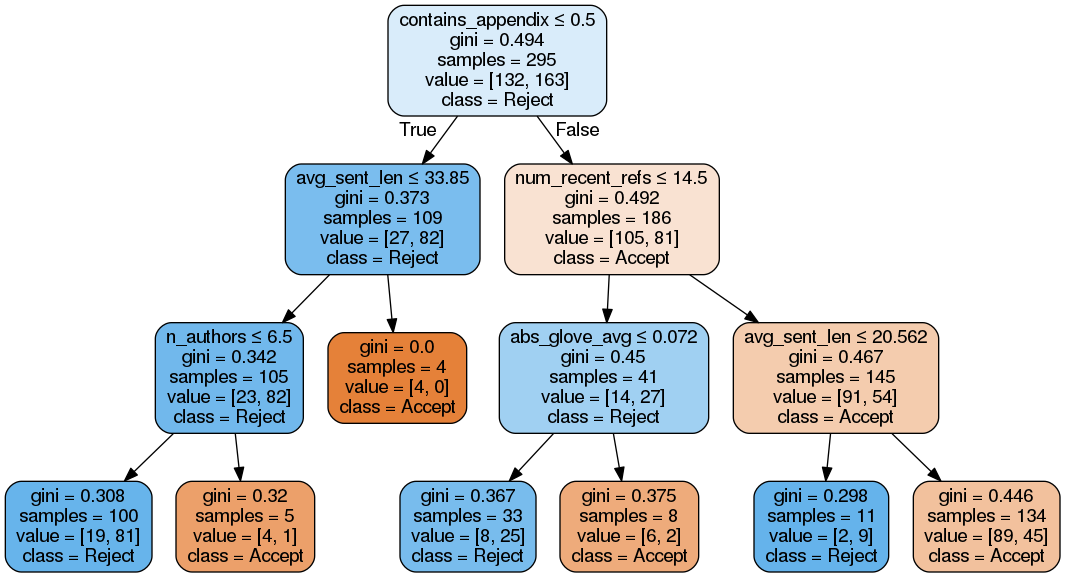

In [35]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_max', 'gs_cit_min', 'gs_cit_med', 'gs_pub_mean', 'gs_pub_max', 'gs_pub_min', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [36]:
# Results without any publication and citation count feature
model_results

,Accuracy,CVresults
KNN,0.5057,"{'fit_time': [0.0021543502807617188, 0.0019714..."
RidgeClf,0.638904,"{'fit_time': [0.003363370895385742, 0.00313067..."
RandomForest,0.618557,"{'fit_time': [0.008410930633544922, 0.00834107..."
DecisionTree,0.584728,"{'fit_time': [0.002116680145263672, 0.00211024..."
SVC,0.553043,"{'fit_time': [0.00659942626953125, 0.006844520..."
GaussianProcessClf,0.514739,"{'fit_time': [0.07074832916259766, 0.098288774..."
LogisticLassoR,0.641141,"{'fit_time': [0.11442732810974121, 0.034710407..."
LogisticR,0.643424,"{'fit_time': [0.0045893192291259766, 0.0043516..."
NeuralNet,0.580223,"{'fit_time': [0.6035878658294678, 0.8691766262..."
GaussNB,0.643347,"{'fit_time': [0.009160280227661133, 0.00560498..."


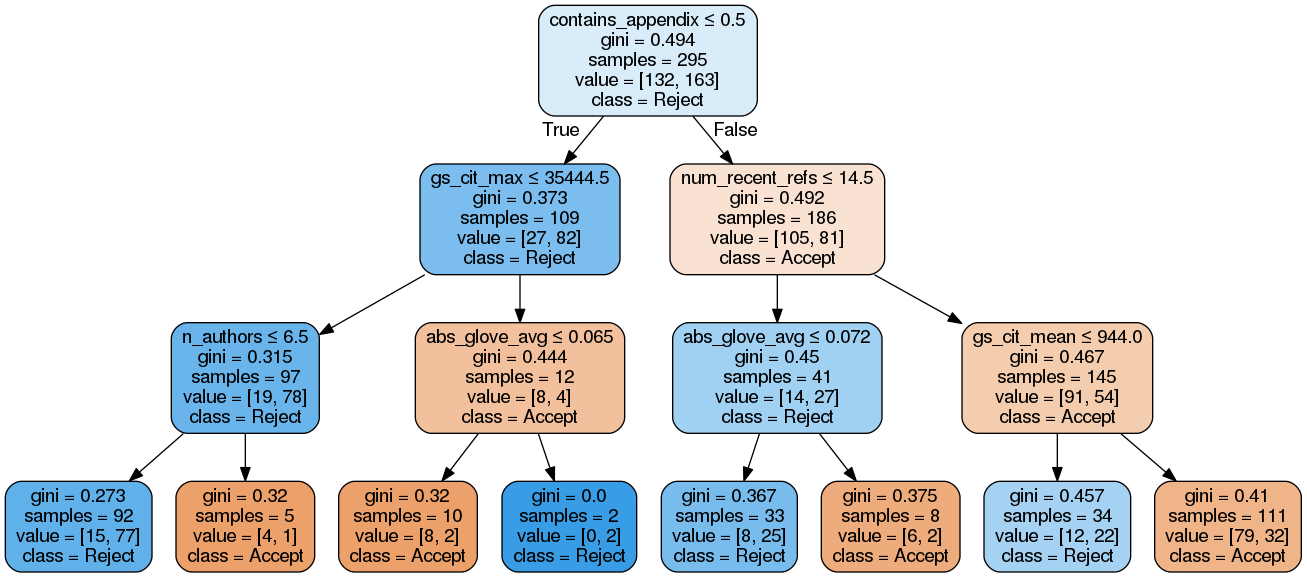

In [47]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_min', 'gs_pub_min'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [48]:
# with all but min
model_results

,Accuracy,CVresults
KNN,0.575719,"{'fit_time': [0.0025017261505126953, 0.0023291..."
RidgeClf,0.614053,"{'fit_time': [0.0034036636352539062, 0.0032460..."
RandomForest,0.613992,"{'fit_time': [0.00913548469543457, 0.009485244..."
DecisionTree,0.609472,"{'fit_time': [0.002524137496948242, 0.00247406..."
SVC,0.553043,"{'fit_time': [0.006253719329833984, 0.00563836..."
GaussianProcessClf,0.444705,"{'fit_time': [0.11430525779724121, 0.217162847..."
LogisticLassoR,0.62081,"{'fit_time': [0.043657541275024414, 0.02500581..."
LogisticR,0.609518,"{'fit_time': [0.00963592529296875, 0.011210680..."
NeuralNet,0.611739,"{'fit_time': [0.2621901035308838, 0.3591396808..."
GaussNB,0.62988,"{'fit_time': [0.0050945281982421875, 0.0048668..."


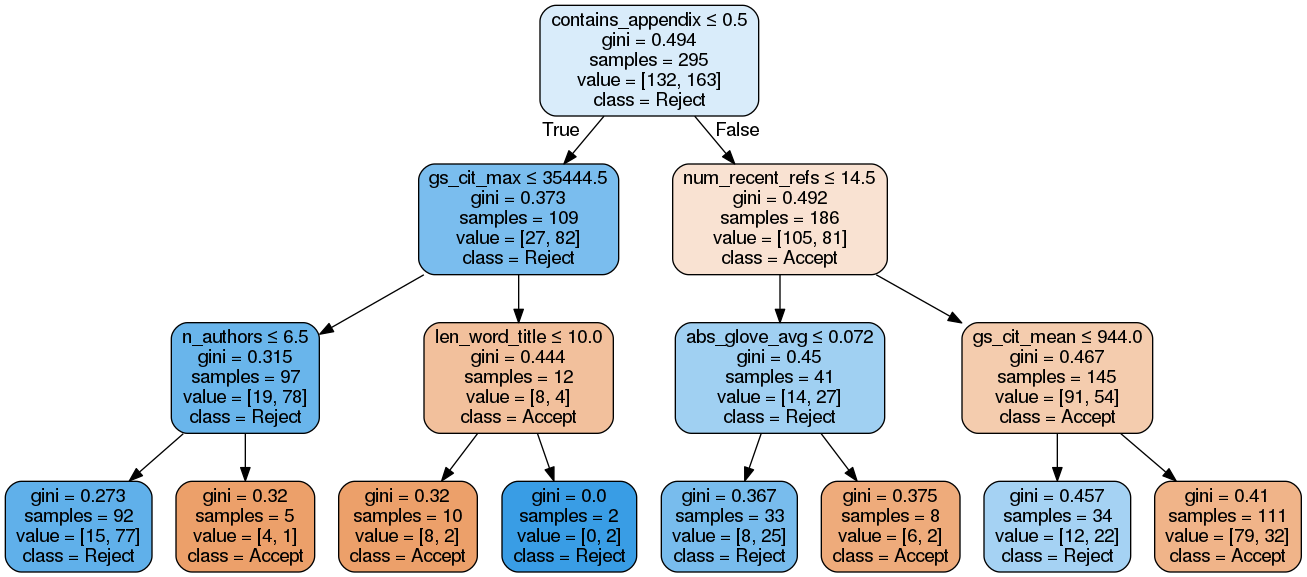

In [45]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [46]:
# with all pub/cit features
model_results

,Accuracy,CVresults
KNN,0.566633,"{'fit_time': [0.002737283706665039, 0.00224113..."
RidgeClf,0.611801,"{'fit_time': [0.0033740997314453125, 0.0032548..."
RandomForest,0.623062,"{'fit_time': [0.00970911979675293, 0.009387969..."
DecisionTree,0.611739,"{'fit_time': [0.0026504993438720703, 0.0025975..."
SVC,0.553043,"{'fit_time': [0.007459878921508789, 0.00584387..."
GaussianProcessClf,0.444705,"{'fit_time': [0.1139681339263916, 0.1930596828..."
LogisticLassoR,0.625283,"{'fit_time': [0.11105561256408691, 0.015978574..."
LogisticR,0.616259,"{'fit_time': [0.014408588409423828, 0.01317095..."
NeuralNet,0.568901,"{'fit_time': [0.6428775787353516, 0.8857061862..."
GaussNB,0.582154,"{'fit_time': [0.004914999008178711, 0.00489854..."


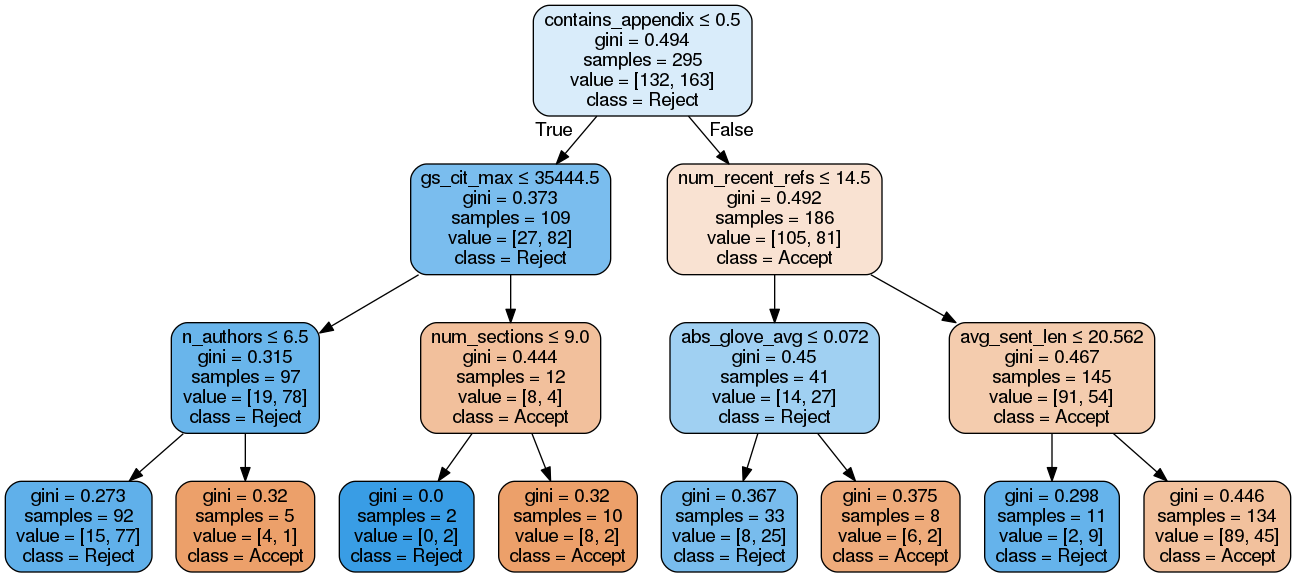

In [37]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_min', 'gs_cit_med', 'gs_pub_mean', 'gs_pub_min', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [38]:
# Keep only max pub and citation counts
model_results

,Accuracy,CVresults
KNN,0.571122,"{'fit_time': [0.0020987987518310547, 0.0020823..."
RidgeClf,0.623077,"{'fit_time': [0.0033652782440185547, 0.0032298..."
RandomForest,0.598195,"{'fit_time': [0.009006738662719727, 0.00868248..."
DecisionTree,0.611938,"{'fit_time': [0.002295970916748047, 0.00226163..."
SVC,0.553043,"{'fit_time': [0.005812883377075195, 0.00530648..."
GaussianProcessClf,0.442453,"{'fit_time': [0.07161974906921387, 0.212117433..."
LogisticLassoR,0.62988,"{'fit_time': [0.09938788414001465, 0.018532276..."
LogisticR,0.627582,"{'fit_time': [0.005980968475341797, 0.00430917..."
NeuralNet,0.55983,"{'fit_time': [0.6411910057067871, 0.7451117038..."
GaussNB,0.656922,"{'fit_time': [0.013526678085327148, 0.00566291..."


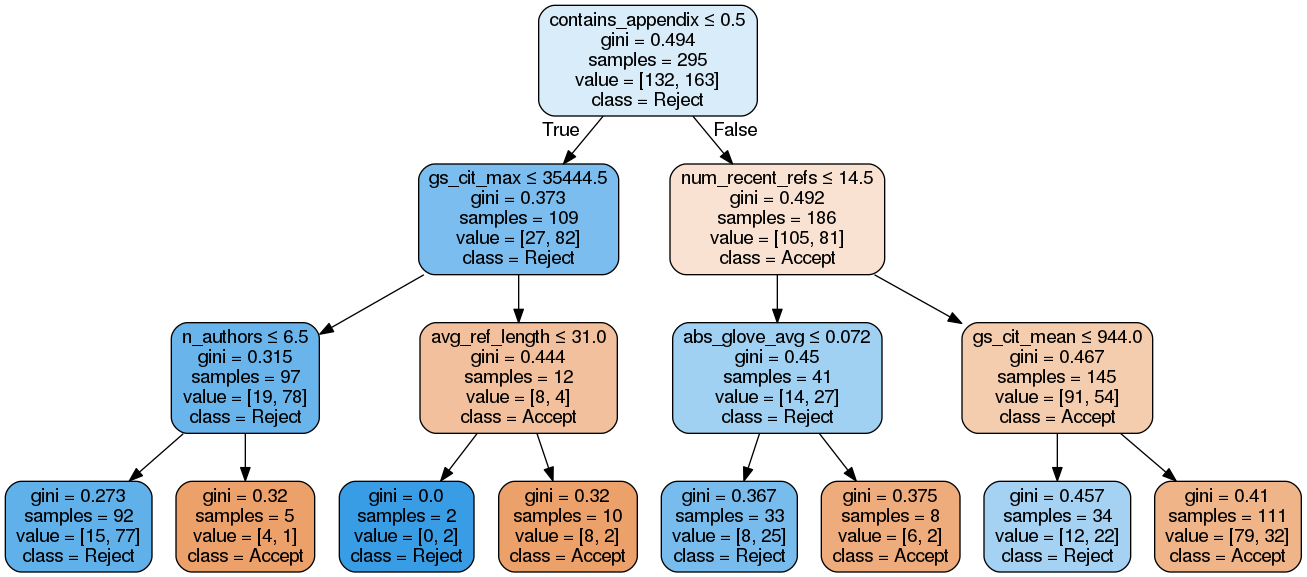

In [39]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_min', 'gs_cit_med', 'gs_pub_min', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [40]:
#with max and mean
model_results

,Accuracy,CVresults
KNN,0.582414,"{'fit_time': [0.003984689712524414, 0.00352358..."
RidgeClf,0.623077,"{'fit_time': [0.004645824432373047, 0.00581359..."
RandomForest,0.605028,"{'fit_time': [0.009366512298583984, 0.00942516..."
DecisionTree,0.618527,"{'fit_time': [0.0023839473724365234, 0.0023422..."
SVC,0.553043,"{'fit_time': [0.0063741207122802734, 0.0055484..."
GaussianProcessClf,0.444705,"{'fit_time': [0.07306146621704102, 0.079091310..."
LogisticLassoR,0.623062,"{'fit_time': [0.10101127624511719, 0.012390375..."
LogisticR,0.620764,"{'fit_time': [0.008134603500366211, 0.00737166..."
NeuralNet,0.620687,"{'fit_time': [0.7145051956176758, 0.6421091556..."
GaussNB,0.647883,"{'fit_time': [0.0051920413970947266, 0.0046966..."


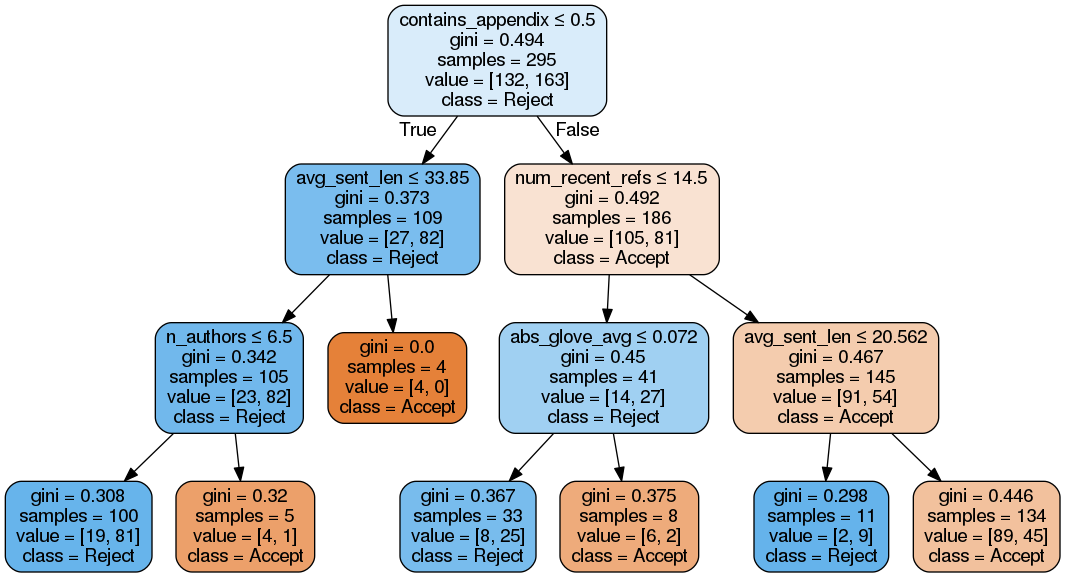

In [41]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_max', 'gs_cit_med', 'gs_pub_mean', 'gs_pub_max', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [42]:
# with min
model_results

,Accuracy,CVresults
KNN,0.53956,"{'fit_time': [0.0020818710327148438, 0.0019588..."
RidgeClf,0.634369,"{'fit_time': [0.0033979415893554688, 0.0038158..."
RandomForest,0.607128,"{'fit_time': [0.010560035705566406, 0.00871849..."
DecisionTree,0.58246,"{'fit_time': [0.0022482872009277344, 0.0022685..."
SVC,0.553043,"{'fit_time': [0.007474422454833984, 0.00570178..."
GaussianProcessClf,0.501149,"{'fit_time': [0.12363457679748535, 0.178669691..."
LogisticLassoR,0.647929,"{'fit_time': [0.09217405319213867, 0.035084486..."
LogisticR,0.636621,"{'fit_time': [0.00656437873840332, 0.006334543..."
NeuralNet,0.573451,"{'fit_time': [0.7055754661560059, 0.7089745998..."
GaussNB,0.591147,"{'fit_time': [0.004946470260620117, 0.00482058..."


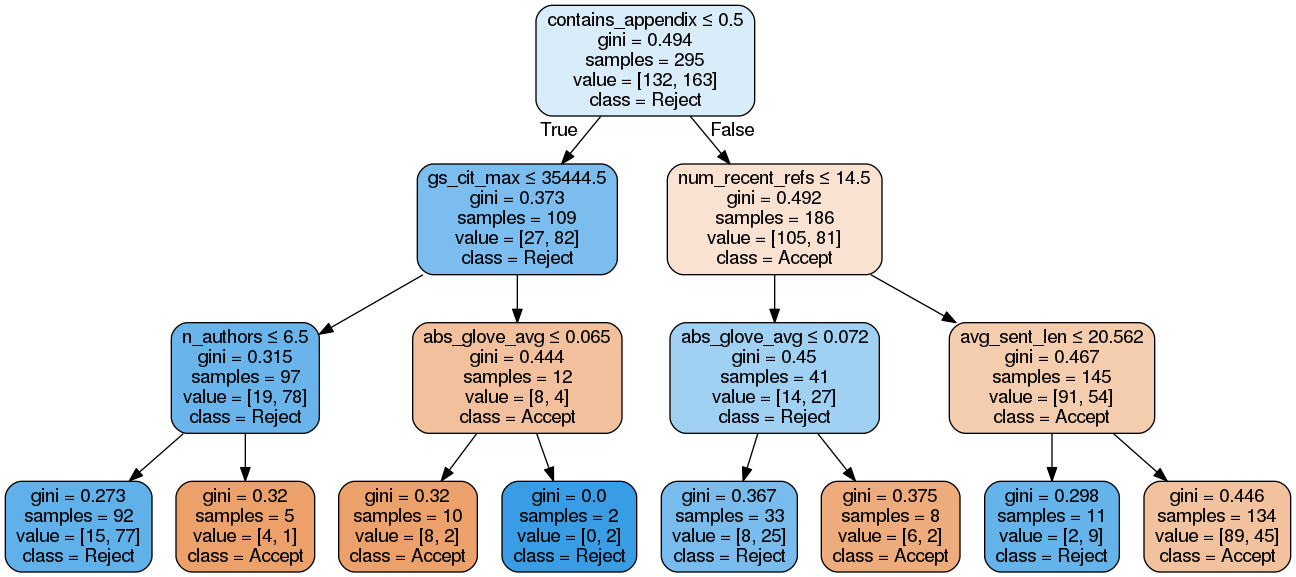

In [43]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
#   X = data.drop(columns=['id','label'])
    X = data.drop(columns=['id','label', 'max_pub', 'max_cit', 'gs_cit_mean', 'gs_cit_med', 'gs_pub_mean', 'gs_pub_med'])
    X_normalized = normalize(X)
    y = data['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [44]:
#with max and min
model_results

,Accuracy,CVresults
KNN,0.557501,"{'fit_time': [0.0023849010467529297, 0.0020890..."
RidgeClf,0.627597,"{'fit_time': [0.0034093856811523438, 0.0036144..."
RandomForest,0.611693,"{'fit_time': [0.011404275894165039, 0.00929594..."
DecisionTree,0.584682,"{'fit_time': [0.002382993698120117, 0.00233411..."
SVC,0.553043,"{'fit_time': [0.0061910152435302734, 0.0065531..."
GaussianProcessClf,0.444705,"{'fit_time': [0.07733654975891113, 0.187319040..."
LogisticLassoR,0.62536,"{'fit_time': [0.053414344787597656, 0.05744647..."
LogisticR,0.625391,"{'fit_time': [0.00906515121459961, 0.009744405..."
NeuralNet,0.575642,"{'fit_time': [0.7176752090454102, 0.6795418262..."
GaussNB,0.582123,"{'fit_time': [0.005490303039550781, 0.00589513..."
